In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from ACAgraphML.Dataset import ZINC_Dataset

dataset = ZINC_Dataset.SMALL_TRAIN.load()
print(f"Number of graphs in the dataset: {len(dataset)}")

Number of graphs in the dataset: 10000


In [3]:
dataset.print_summary()

100%|██████████| 10000/10000 [00:01<00:00, 5784.58it/s]

ZINC (#graphs=10000):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     23.2 |     49.9 |
| std        |      4.5 |     10.6 |
| min        |      9   |     16   |
| quantile25 |     20   |     42   |
| median     |     23   |     50   |
| quantile75 |     26   |     56   |
| max        |     37   |     82   |
+------------+----------+----------+


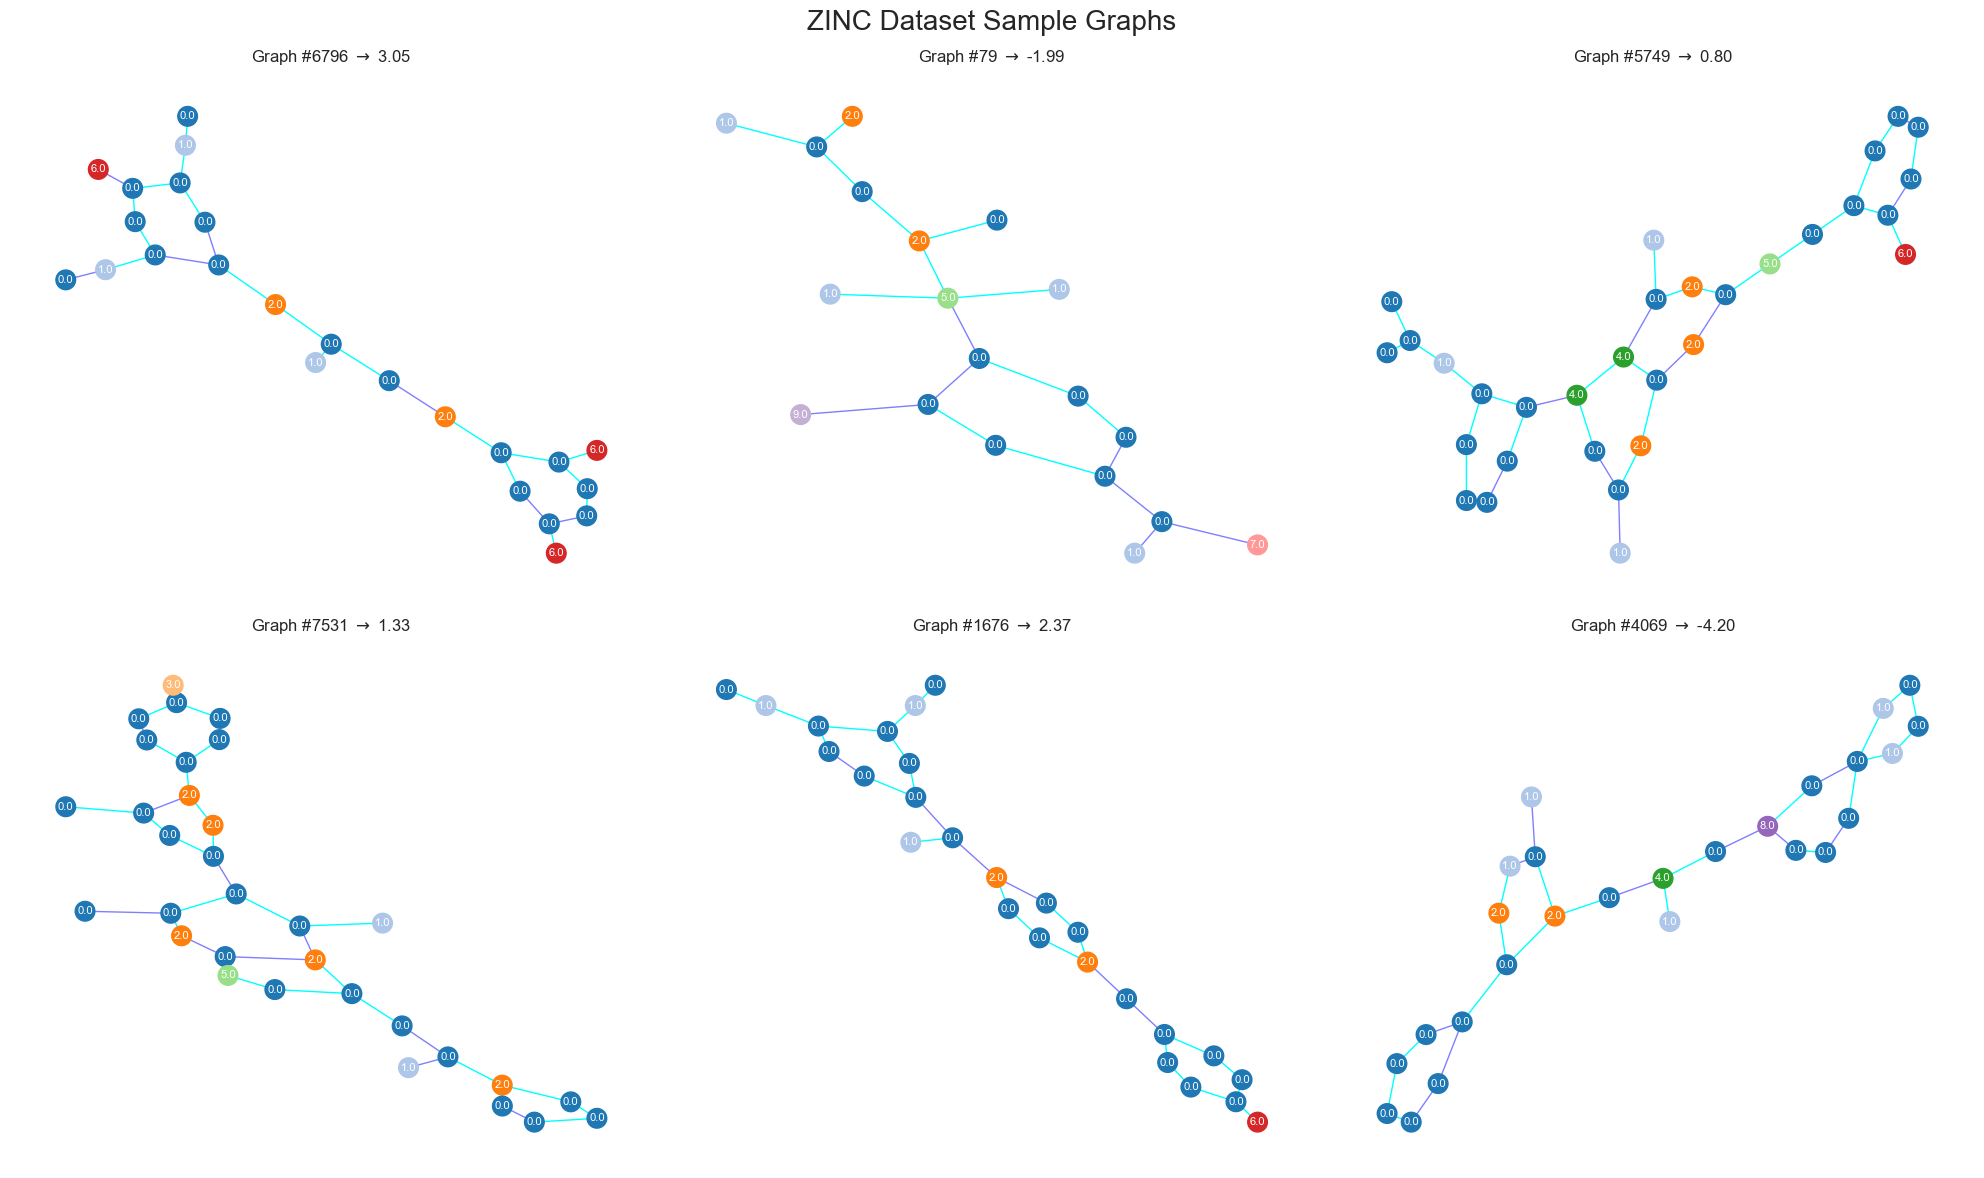

In [4]:
from ACAgraphML.Plotting import plotGraph
import numpy as np
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('ZINC Dataset Sample Graphs', fontsize=20)
for i in range(6):
    n = np.random.randint(0, len(dataset))
    graph = dataset.get(n)
    plotGraph(graph, title=f'Graph #{n} $\\rightarrow$ {graph.y.item():.2f}', ax=axs[i // 3, i % 3])
plt.tight_layout()
plt.show()
    

# Node analysis

In [5]:
def plotDistribution(data, title, bins=30):
    plt.figure(figsize=(10, 6))
    mean = data.mean()
    std = data.std()
    print(f"{title} Mean: {mean:.4f}, Std: {std:.4f}")
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    plt.axvline(mean + std, color='green', linestyle='--', label=f'Mean + Std: {mean + std:.4f}')
    plt.axvline(mean - std, color='green', linestyle='--', label=f'Mean - Std: {mean - std:.4f}')
    sns.histplot(data, kde=True, bins=bins)
    plt.title(title + ' Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Node Count Mean: 23.1664, Std: 4.4895


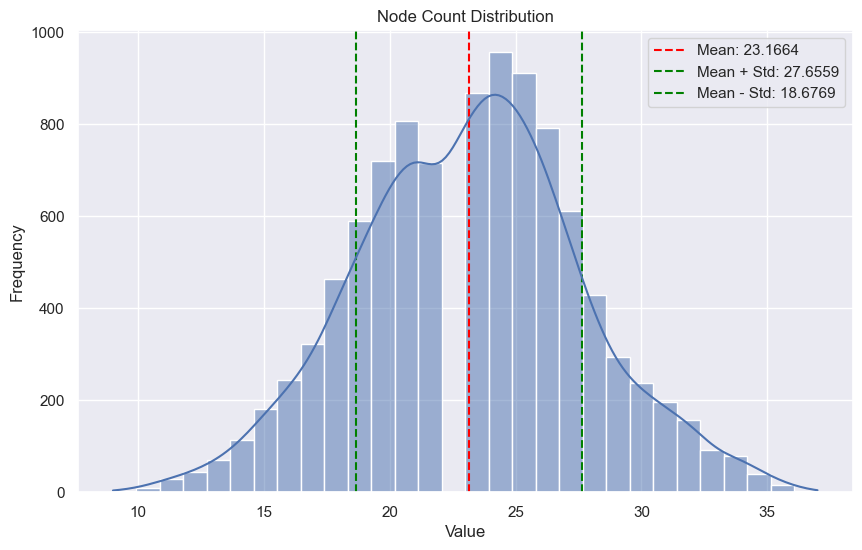

In [6]:
node_counts = torch.Tensor([g.x.shape[0] for g in dataset])
plotDistribution(node_counts, "Node Count")

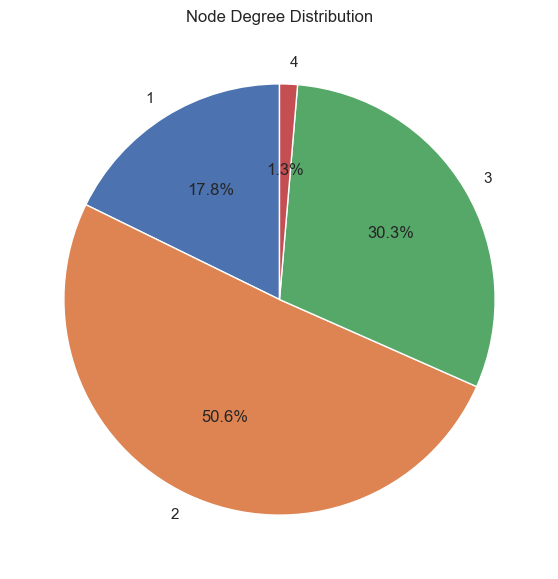

In [7]:
# Compute the degree of each node
_, degs = torch.unique_consecutive(dataset._data.edge_index[0], return_counts=True)
degs = degs.float()

degree_counts = degs.int().bincount()[1:]
labels = [str(i+1) for i in range(len(degree_counts))]
plt.figure(figsize=(7, 7))
plt.pie(degree_counts, labels=labels, autopct='%1.1f%%', startangle=90, )
plt.title('Node Degree Distribution')
plt.show()

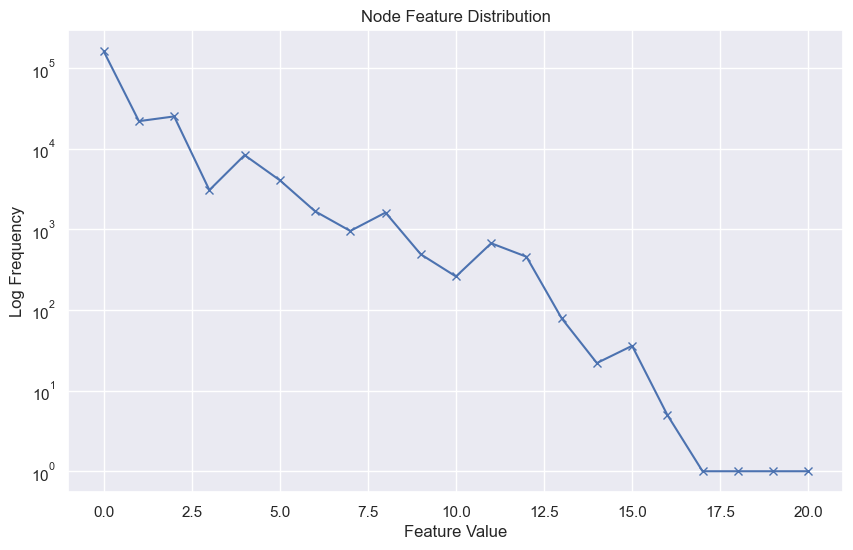

In [8]:
# Node feature distribution
node_features = dataset.x.squeeze()
node_features.bincount()
plt.figure(figsize=(10, 6))
plt.plot(node_features.bincount().numpy(), marker='x')
plt.title('Node Feature Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Log Frequency')
plt.yscale('log')
plt.show()

# Edge Analysis

Edge Count Mean: 49.8558, Std: 10.5644


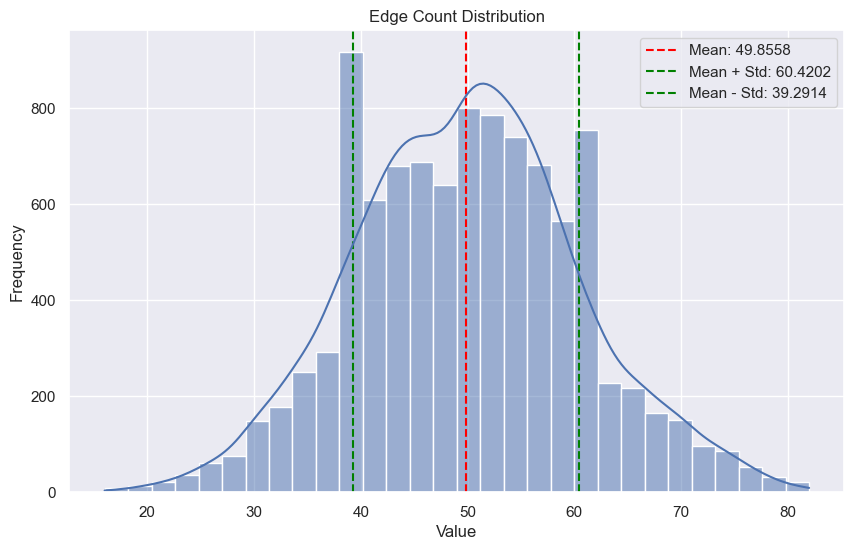

In [9]:
edgeCount = torch.Tensor([g.edge_index.shape[1] for g in dataset])
plotDistribution(edgeCount, "Edge Count")

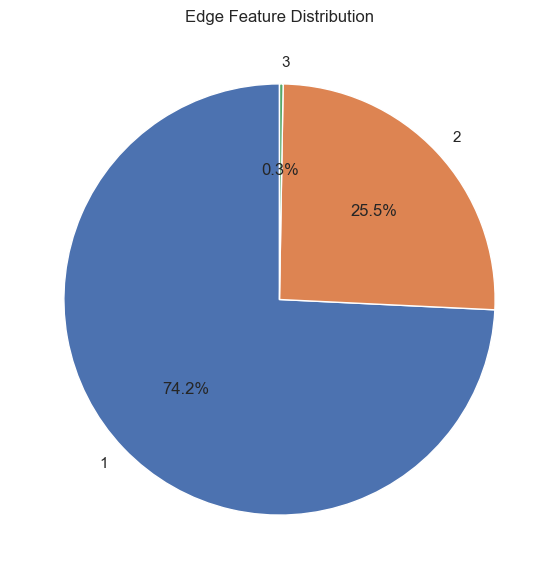

In [10]:
#Edge feature distribution as a pie chart
edge_features = dataset.edge_attr.squeeze()
edge_features_count = edge_features.bincount()[1:]
labels = [str(i+1) for i in range(len(edge_features_count))]
plt.figure(figsize=(7, 7))
plt.pie(edge_features_count, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Edge Feature Distribution')
plt.show()


# Target Analysis

Target Value Distribution Mean: 0.0153, Std: 2.0109


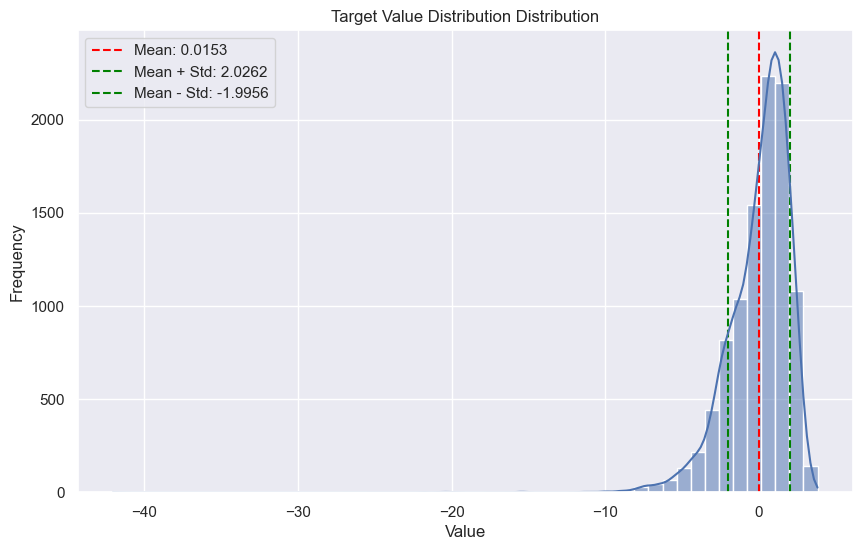

In [11]:
target_values = dataset.y.squeeze()
plotDistribution(target_values, "Target Value Distribution", bins=50)

# Looking for correlations

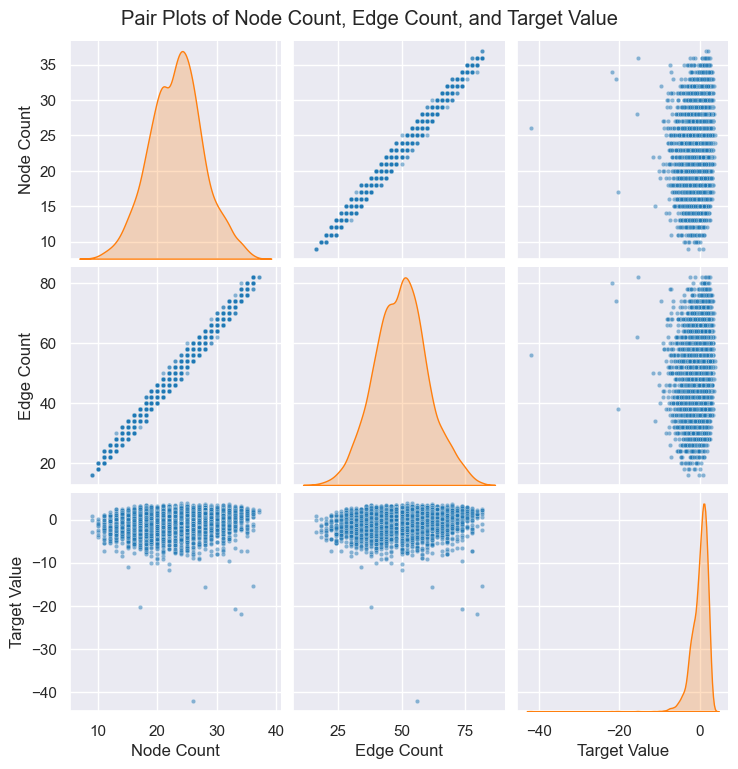

In [12]:
# sns pair plots between number of nodes, number of edges and target value
import pandas as pd
df = pd.DataFrame({
    'Node Count': node_counts.numpy(),
    'Edge Count': edgeCount.numpy(),
    'Target Value': target_values.numpy()
})
sns.pairplot(
    df,
    diag_kind='kde',
    kind='scatter',
    markers='o',
    plot_kws={'alpha': 0.5, 's': 10, 'color': '#1f77b4'},
    diag_kws={'color': '#ff7f0e', 'fill': True},
)
plt.suptitle('Pair Plots of Node Count, Edge Count, and Target Value', y=1.02)
plt.show()


# Anomaly Analysis

Target Mean: 0.0153, Std: 2.0109
Number of anomalies: 107
Top 10 anomalies (by delta from mean):
Anomaly #1: Target Value = -42.0366, Normalized Delta = 20.9117
Anomaly #2: Target Value = -21.9071, Normalized Delta = 10.9017
Anomaly #3: Target Value = -20.7828, Normalized Delta = 10.3426
Anomaly #4: Target Value = -20.2606, Normalized Delta = 10.0829
Anomaly #5: Target Value = -15.5405, Normalized Delta = 7.7357
Anomaly #6: Target Value = -15.3271, Normalized Delta = 7.6295
Anomaly #7: Target Value = -11.5659, Normalized Delta = 5.7591
Anomaly #8: Target Value = -11.0507, Normalized Delta = 5.5030
Anomaly #9: Target Value = -10.2191, Normalized Delta = 5.0894
Anomaly #10: Target Value = -10.0416, Normalized Delta = 5.0011


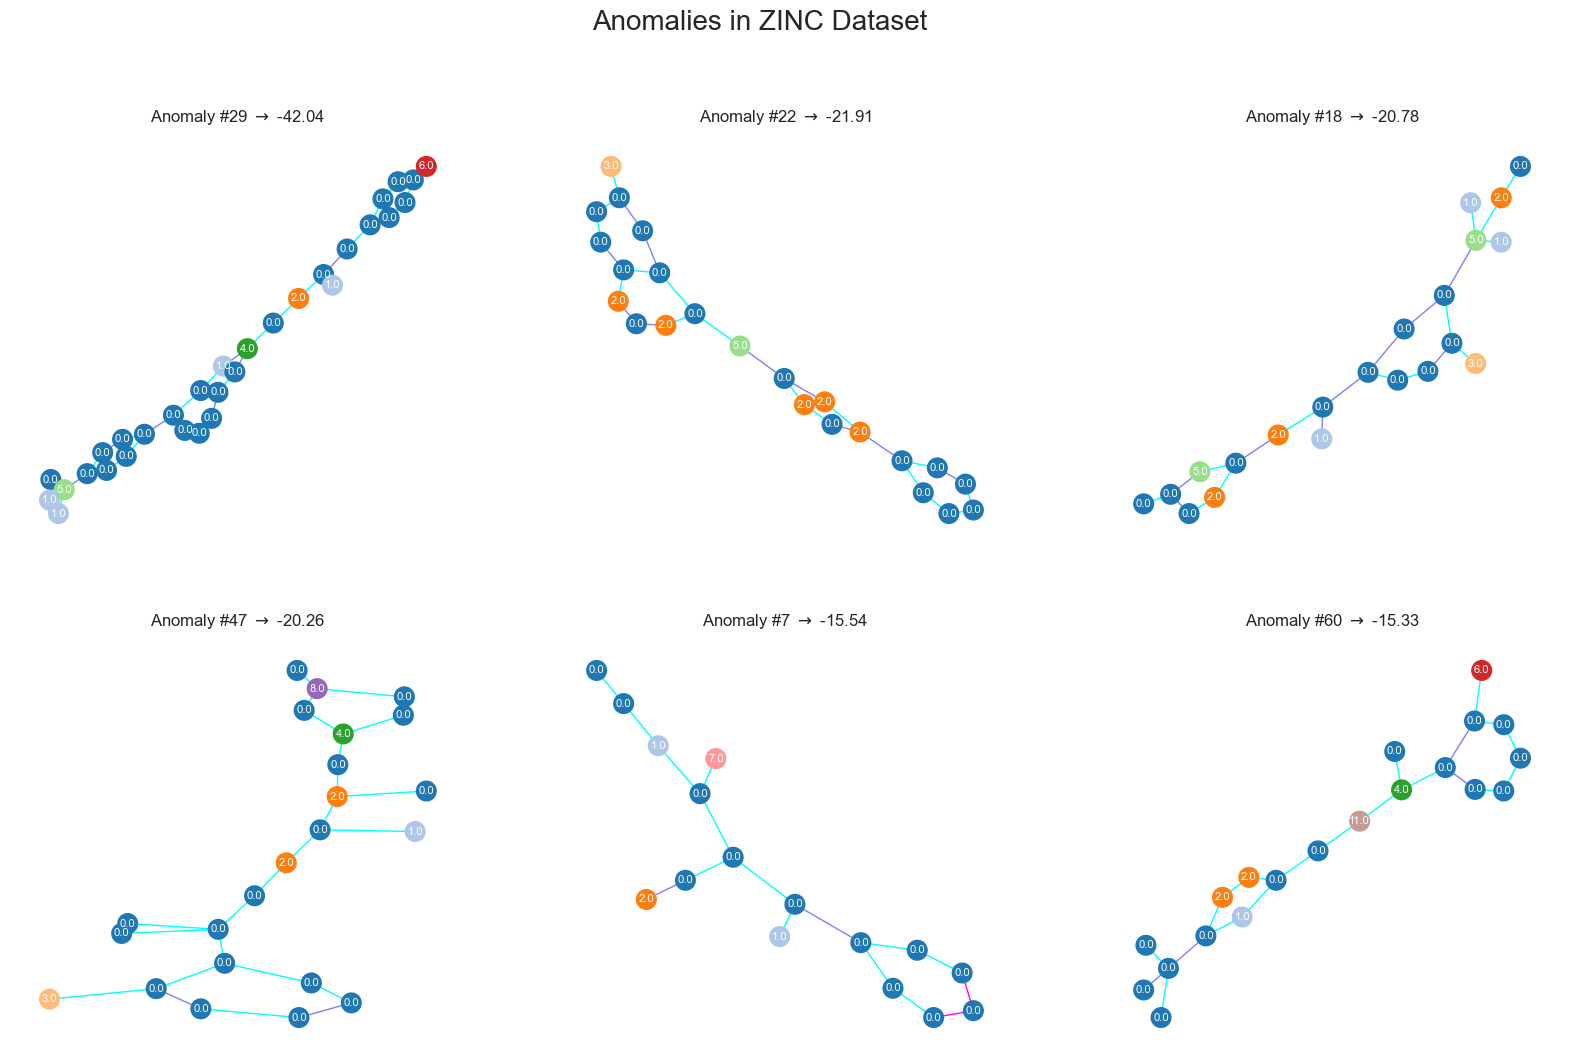

In [29]:
#Extract all the fraph in the training set that have the target more than 3 standard deviations from the mean
mean = target_values.mean()
std = target_values.std()
print(f"Target Mean: {mean:.4f}, Std: {std:.4f}")
anomalies = dataset[torch.abs(target_values - mean) > 3 * std]
target_values_anomalies = target_values[torch.abs(target_values - mean) > 3 * std]
normalized_anomalies = (target_values_anomalies - mean) / std
abs_normalized_anomalies = torch.abs(normalized_anomalies)

print(f"Number of anomalies: {len(anomalies)}")

#Rank the anomalies by delta from the mean
anomaly_indices = torch.argsort(abs_normalized_anomalies, descending=True)
anomaliesRanked = anomalies[anomaly_indices]

print(f"Top 10 anomalies (by delta from mean):")
for i in range(10):
    print(f"Anomaly #{i+1}: Target Value = {target_values_anomalies[anomaly_indices[i]]:.4f}, Normalized Delta = {abs_normalized_anomalies[anomaly_indices[i]]:.4f}")

# Plot the anomalies
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Anomalies in ZINC Dataset', fontsize=20)
for i in range(6):
    n = anomaly_indices[i].item()
    graph = anomaliesRanked.get(n)
    plotGraph(graph, title=f'Anomaly #{n} $\\rightarrow$ {target_values_anomalies[n]:.2f}', ax=axs[i // 3, i % 3])